In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
df=pd.read_csv('/content/btc_actual_price.csv', index_col='Date',parse_dates=['Date'])
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (978, 9)


,Nasdaq,S&P500,Japan,Euronext100,Gold,Silver,WTI ($/barrel),Brent Crude($/barrel),Bitcoin
Date,,,,,,,,,
2017-01-04,5477.0000,2270.7500,19594.1600,941.2700,1163.8000,16.4990,53.2600,54.5700,1037.5000
2017-01-05,5487.9400,2269.0000,19520.6900,941.1700,1179.7000,16.5840,53.7700,54.9900,1139.6000
2017-01-06,5521.0600,2276.9800,19454.3300,941.7100,1171.9000,16.4660,53.9800,55.9000,1003.8000
2017-01-10,5551.8200,2268.9000,19301.4400,937.6200,1184.2000,16.8030,50.8200,53.2000,903.0000
2017-01-11,5563.6500,2275.3200,19364.6700,938.1800,1195.6000,16.7830,52.1900,53.6100,905.7600


In [ ]:
stat, p = stats.normaltest(df.Bitcoin)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=658.895, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 10.565877306132952
Skewness of normal distribution: 3.12950976711765


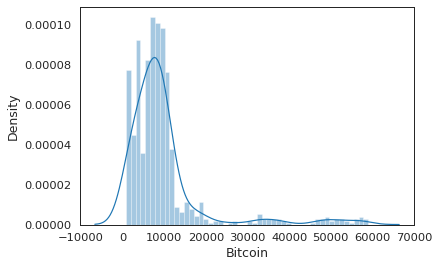

In [ ]:
sns.distplot(df.Bitcoin);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Bitcoin)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Bitcoin)))

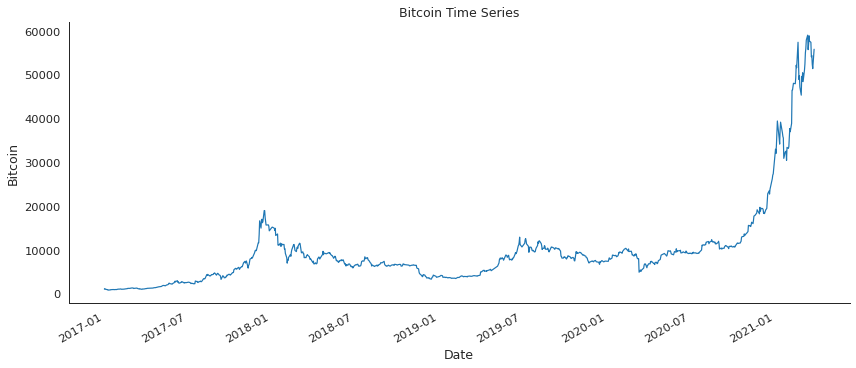

In [ ]:
df1=df.loc[:,['Bitcoin']]
df1.plot(figsize=(12,5))
plt.ylabel('Bitcoin')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Bitcoin Time Series')
sns.despine(top=True)
plt.show();

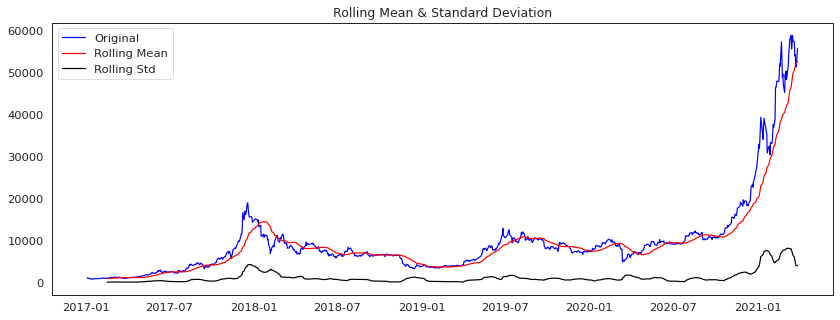

<Results of Dickey-Fuller Test>
Test Statistic                  2.9075
p-value                         1.0000
#Lags Used                     20.0000
Number of Observations Used   957.0000
Critical Value (1%)            -3.4372
Critical Value (5%)            -2.8646
Critical Value (10%)           -2.5684
dtype: float64


In [ ]:
df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Bitcoin.dropna())

In [ ]:
dataset = df.Bitcoin.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.92)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((868, 1, 30), (48, 1, 30), (868,), (48,))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=64)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [ ]:
train_predict.shape, Y_train.shape, test_predict.shape, Y_test.shape

((868, 1), (1, 868), (48, 1), (1, 48))

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train.transpose(), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train.transpose(), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test.transpose(), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test.transpose(), test_predict[:,0])))

Train Mean Absolute Error: 427.9899912503157
Train Root Mean Squared Error: 551.3676274957169
Test Mean Absolute Error: 5438.392615216629
Test Root Mean Squared Error: 6259.247743334998


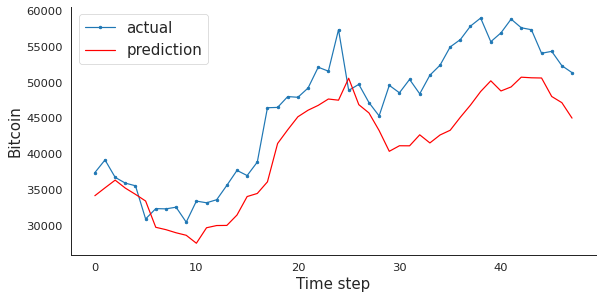

In [ ]:
aa=[x for x in range(48)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:48], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:48], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

#**Predicting Changes in respective markets**

In [ ]:
df=pd.read_csv('/content/btc_change_per.csv', index_col='Date',parse_dates=['Date'])
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (958, 9)


,Change_Nasdaq,Change_SP500,Change_Japan,Change_Euronext_100,Change_Gold,Change_Silver,Change_WTI_Oil,Change_Brent_Oil,Bitcoin
Date,,,,,,,,,
2017-01-04,0.8827,0.5722,0.0000,-0.0085,0.2930,0.8743,1.7189,-0.8719,1037.5000
2017-01-05,0.1997,-0.0771,-0.3750,-0.0106,1.3662,0.5152,0.9576,0.7696,1139.6000
2017-01-06,0.6035,0.3517,-0.3399,0.0574,-0.6612,-0.7115,0.3906,1.6548,1003.8000
2017-01-10,0.3615,0.0000,-0.7859,-0.0650,0.0591,1.0403,-2.1752,-2.1879,903.0000
2017-01-11,0.2131,0.2830,0.3276,0.0597,0.9627,-0.1190,2.6958,0.7707,905.7600


In [ ]:
stat, p = stats.normaltest(df.Bitcoin)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=643.717, p=0.000
Data does not look Gaussian (reject H0)


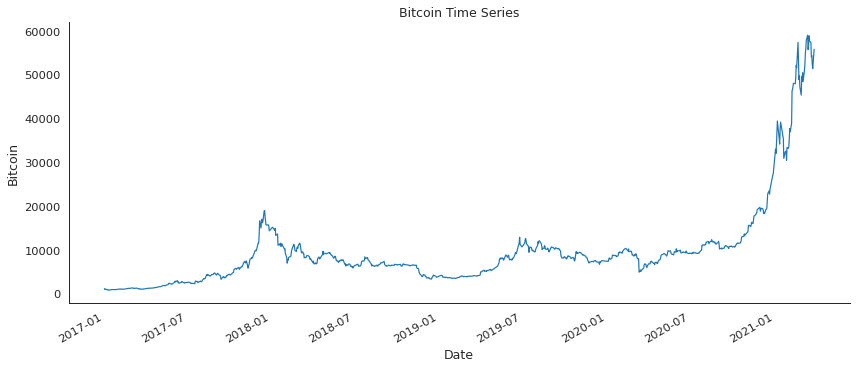

In [ ]:
df1=df.loc[:,['Bitcoin']]
df1.plot(figsize=(12,5))
plt.ylabel('Bitcoin')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Bitcoin Time Series')
sns.despine(top=True)
plt.show();

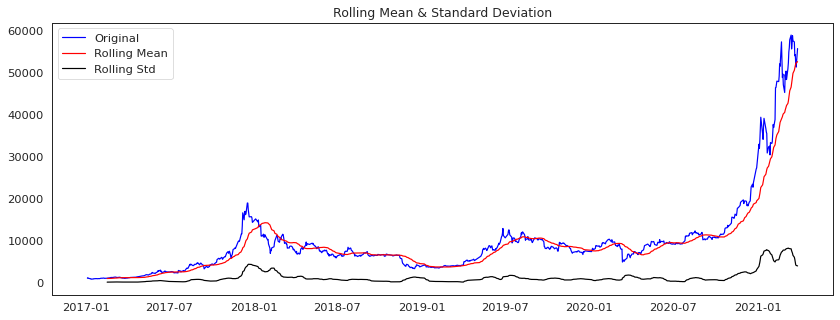

<Results of Dickey-Fuller Test>
Test Statistic                  3.0865
p-value                         1.0000
#Lags Used                     19.0000
Number of Observations Used   938.0000
Critical Value (1%)            -3.4373
Critical Value (5%)            -2.8646
Critical Value (10%)           -2.5684
dtype: float64


In [ ]:
df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Bitcoin.dropna())

In [ ]:
dataset = df.Bitcoin.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.92)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((850, 1, 30), (46, 1, 30), (850,), (46,))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=250, batch_size=64)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train.transpose(), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train.transpose(), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test.transpose(), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test.transpose(), test_predict[:,0])))

Train Mean Absolute Error: 280.90464240768364
Train Root Mean Squared Error: 431.4184522568092
Test Mean Absolute Error: 5689.095183279725
Test Root Mean Squared Error: 6415.609087845996


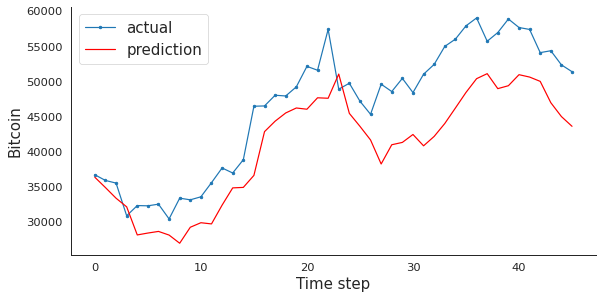

In [ ]:
aa=[x for x in range(46)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:46], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:46], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# **Ethereum Predictions**

In [ ]:
df=pd.read_csv('/content/eth_actual_price.csv', index_col='Date',parse_dates=['Date'])
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (978, 9)


,Nasdaq,S&P500,Japan,Euronext100,Gold,Silver,WTI ($/barrel),Brent Crude($/barrel),Ethereum
Date,,,,,,,,,
2017-01-04,5477.0000,2270.7500,19594.1600,941.2700,1163.8000,16.4990,53.2600,54.5700,9.6610
2017-01-05,5487.9400,2269.0000,19520.6900,941.1700,1179.7000,16.5840,53.7700,54.9900,11.0750
2017-01-06,5521.0600,2276.9800,19454.3300,941.7100,1171.9000,16.4660,53.9800,55.9000,10.2940
2017-01-10,5551.8200,2268.9000,19301.4400,937.6200,1184.2000,16.8030,50.8200,53.2000,10.3430
2017-01-11,5563.6500,2275.3200,19364.6700,938.1800,1195.6000,16.7830,52.1900,53.6100,10.5220


In [ ]:
stat, p = stats.normaltest(df.Ethereum)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=472.438, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 5.55554016560307
Skewness of normal distribution: 2.3184201030638247


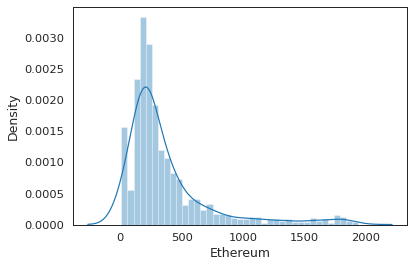

In [ ]:
sns.distplot(df.Ethereum);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Ethereum)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Ethereum)))

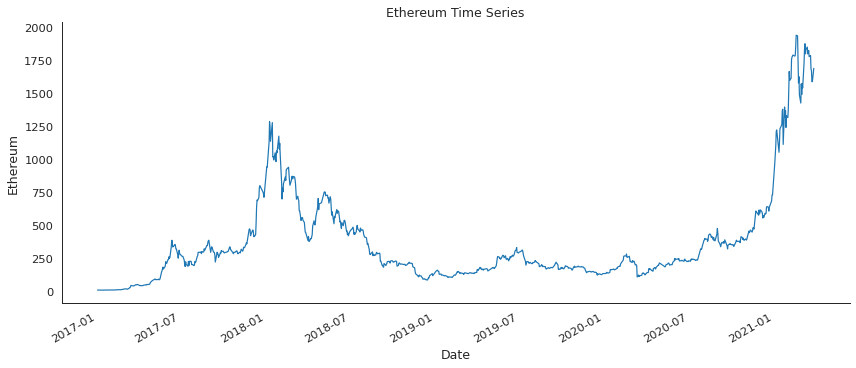

In [ ]:
df1=df.loc[:,['Ethereum']]
df1.plot(figsize=(12,5))
plt.ylabel('Ethereum')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Ethereum Time Series')
sns.despine(top=True)
plt.show();

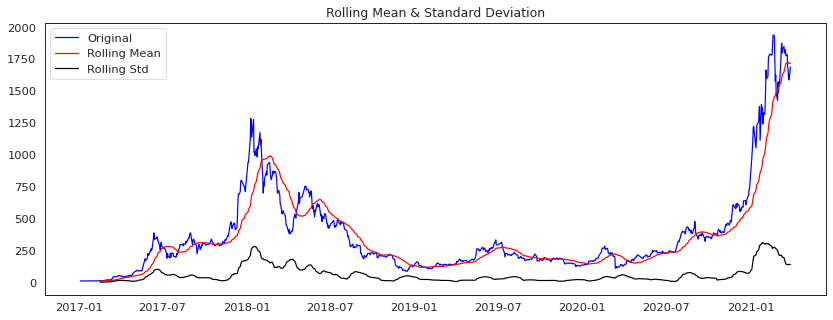

<Results of Dickey-Fuller Test>
Test Statistic                 -0.4936
p-value                         0.8933
#Lags Used                     22.0000
Number of Observations Used   955.0000
Critical Value (1%)            -3.4372
Critical Value (5%)            -2.8646
Critical Value (10%)           -2.5684
dtype: float64


In [ ]:
df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Ethereum.dropna())

In [ ]:
dataset = df.Ethereum.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.92)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((868, 1, 30), (48, 1, 30), (868,), (48,))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=64)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train.transpose(), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train.transpose(), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test.transpose(), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test.transpose(), test_predict[:,0])))

Train Mean Absolute Error: 15.903623559814076
Train Root Mean Squared Error: 25.987491736375812
Test Mean Absolute Error: 265.5553096323954
Test Root Mean Squared Error: 296.1354606831421


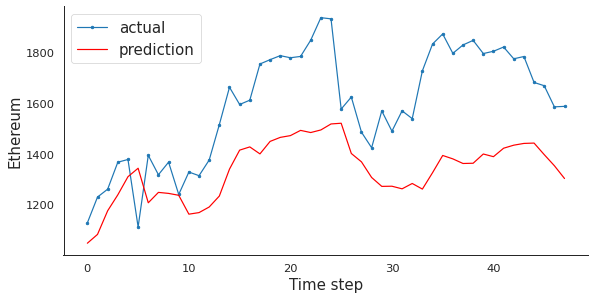

In [ ]:
aa=[x for x in range(48)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:48], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:48], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Ethereum', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## **Change Percentage**

In [ ]:
df=pd.read_csv('/content/eth_change_per.csv', index_col='Date',parse_dates=['Date'])
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (958, 9)


,Change_Nasdaq,Change_SP500,Change_Japan,Change_Euronext_100,Change_Gold,Change_Silver,Change_WTI_Oil,Change_Brent_Oil,Ethereum
Date,,,,,,,,,
2017-01-04,0.8827,0.5722,0.0000,-0.0085,0.2930,0.8743,1.7189,-0.8719,9.6610
2017-01-05,0.1997,-0.0771,-0.3750,-0.0106,1.3662,0.5152,0.9576,0.7696,11.0750
2017-01-06,0.6035,0.3517,-0.3399,0.0574,-0.6612,-0.7115,0.3906,1.6548,10.2940
2017-01-10,0.3615,0.0000,-0.7859,-0.0650,0.0591,1.0403,-2.1752,-2.1879,10.3430
2017-01-11,0.2131,0.2830,0.3276,0.0597,0.9627,-0.1190,2.6958,0.7707,10.5220


In [ ]:
stat, p = stats.normaltest(df.Ethereum)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=469.696, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 5.686182215532819
Skewness of normal distribution: 2.3467317020924154


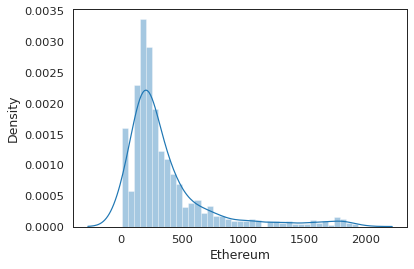

In [ ]:
sns.distplot(df.Ethereum);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Ethereum)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Ethereum)))

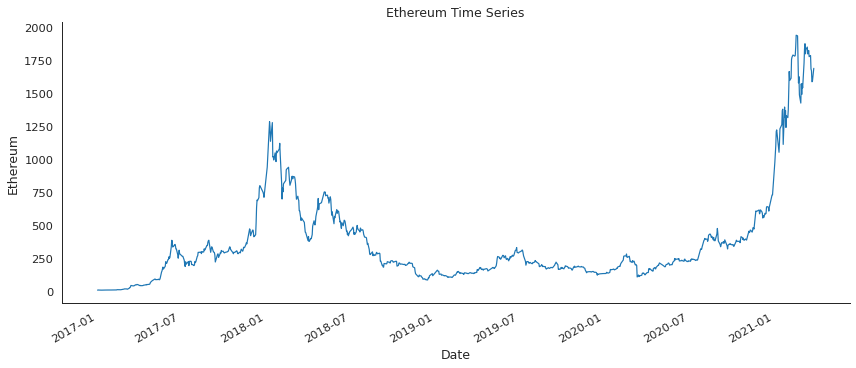

In [ ]:
df1=df.loc[:,['Ethereum']]
df1.plot(figsize=(12,5))
plt.ylabel('Ethereum')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Ethereum Time Series')
sns.despine(top=True)
plt.show();

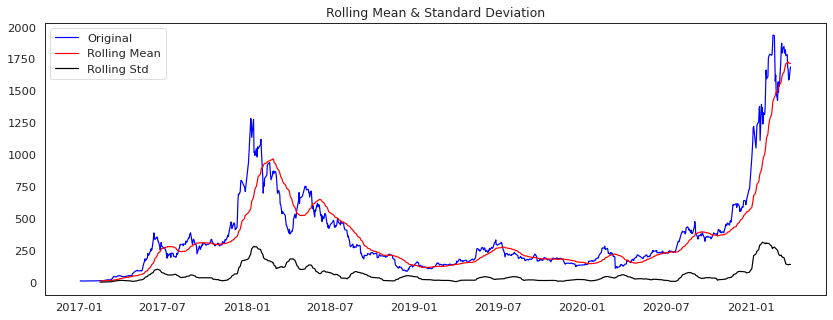

<Results of Dickey-Fuller Test>
Test Statistic                 -0.8099
p-value                         0.8162
#Lags Used                     21.0000
Number of Observations Used   936.0000
Critical Value (1%)            -3.4374
Critical Value (5%)            -2.8646
Critical Value (10%)           -2.5684
dtype: float64


In [ ]:
df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Ethereum.dropna())

In [ ]:
dataset = df.Ethereum.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.92)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((850, 1, 30), (46, 1, 30), (850,), (46,))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=64)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train.transpose(), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train.transpose(), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test.transpose(), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test.transpose(), test_predict[:,0])))

Train Mean Absolute Error: 16.330781932650186
Train Root Mean Squared Error: 27.36718242574785
Test Mean Absolute Error: 249.05818344826986
Test Root Mean Squared Error: 277.1077339665169


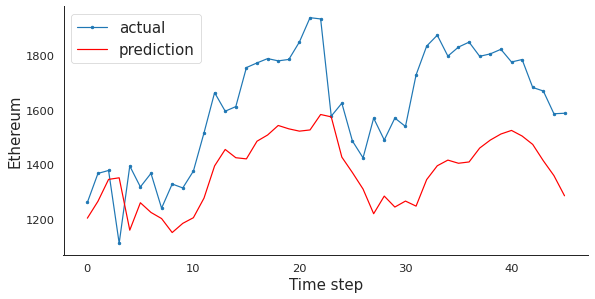

In [ ]:
aa=[x for x in range(46)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:46], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:46], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Ethereum', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();